In [39]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
import numpy as np
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("patrickfleith/nasa-anomaly-detection-dataset-smap-msl")

chan_df = pd.read_csv(path + '/labeled_anomalies.csv')

print("First 5 records:")
chan_df.head()


First 5 records:


,chan_id,spacecraft,anomaly_sequences,class,num_values
0,P-1,SMAP,"[[2149, 2349], [4536, 4844], [3539, 3779]]","[contextual, contextual, contextual]",8505
1,S-1,SMAP,"[[5300, 5747]]",[point],7331
2,E-1,SMAP,"[[5000, 5030], [5610, 6086]]","[contextual, contextual]",8516
3,E-2,SMAP,"[[5598, 6995]]",[point],8532
4,E-3,SMAP,"[[5094, 8306]]",[point],8307


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [41]:
for i, row in chan_df.iterrows():
    print(f"Channel ID: {row['chan_id']}")
    chan_train = np.load(path + f'/data/data/train/{row["chan_id"]}.npy')
    chan_test = np.load(path + f'/data/data/test/{row["chan_id"]}.npy')
    chan_anomalies = np.zeros(chan_test.shape[0], dtype=int)
    for (start, end) in eval(row['anomaly_sequences']):
        chan_anomalies[start:end+1] = 1  # Mark anomalies in the test set
    print(f"  Train shape: {chan_train.shape}, Test shape: {chan_test.shape}")
    break
    


Channel ID: P-1
  Train shape: (2872, 25), Test shape: (8505, 25)


In [42]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


In [43]:
from sklearn.metrics import classification_report

train_data = torch.FloatTensor(chan_train)
train_dataset = TensorDataset(train_data, train_data)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_data = torch.FloatTensor(chan_test)
test_dataset = TensorDataset(test_data, test_data)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = Autoencoder(input_size=chan_train.shape[1], hidden_size=16).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    for batch_data, _ in train_dataloader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_data)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [10/500], Loss: 0.0156
Epoch [20/500], Loss: 0.0138
Epoch [30/500], Loss: 0.0134
Epoch [40/500], Loss: 0.0130
Epoch [50/500], Loss: 0.0128
Epoch [60/500], Loss: 0.0126
Epoch [70/500], Loss: 0.0126
Epoch [80/500], Loss: 0.0125
Epoch [90/500], Loss: 0.0124
Epoch [100/500], Loss: 0.0124
Epoch [110/500], Loss: 0.0123
Epoch [120/500], Loss: 0.0123
Epoch [130/500], Loss: 0.0123
Epoch [140/500], Loss: 0.0123
Epoch [150/500], Loss: 0.0123
Epoch [160/500], Loss: 0.0123
Epoch [170/500], Loss: 0.0122
Epoch [180/500], Loss: 0.0122
Epoch [190/500], Loss: 0.0122
Epoch [200/500], Loss: 0.0122
Epoch [210/500], Loss: 0.0122
Epoch [220/500], Loss: 0.0122
Epoch [230/500], Loss: 0.0122
Epoch [240/500], Loss: 0.0122
Epoch [250/500], Loss: 0.0122
Epoch [260/500], Loss: 0.0122
Epoch [270/500], Loss: 0.0122
Epoch [280/500], Loss: 0.0122
Epoch [290/500], Loss: 0.0122
Epoch [300/500], Loss: 0.0122
Epoch [310/500], Loss: 0.0122
Epoch [320/500], Loss: 0.0122
Epoch [330/500], Loss: 0.0122
Epoch [340/500], Lo

In [44]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    reconstructed = model(test_data.to(device))
    reconstruction_error = torch.mean((test_data.to(device) - reconstructed) ** 2, dim=1).cpu().numpy()

    threshold = np.percentile(reconstruction_error, 95)
    print(f"Reconstruction error threshold (95th percentile): {threshold}")
    anomalies = reconstruction_error > threshold
 
    report_dict = classification_report(chan_anomalies, anomalies, output_dict=True)




Reconstruction error threshold (95th percentile): 0.027491537854075432


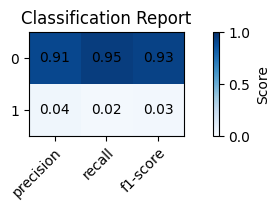

In [45]:
# Extract metrics
classes = [key for key in report_dict.keys() if key not in ('accuracy', 'macro avg', 'weighted avg')]
metrics = ['precision', 'recall', 'f1-score']
values = np.array([[report_dict[c][m] for m in metrics] for c in classes])

# Plot
fig, ax = plt.subplots(figsize=(8, len(classes)*0.6 + 1))
im = ax.imshow(values, cmap='Blues', vmin=0, vmax=1)

# Show all ticks and labels
ax.set_xticks(np.arange(len(metrics)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(metrics)
ax.set_yticklabels(classes)

# Rotate the tick labels and set alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(metrics)):
        text = ax.text(j, i, f"{values[i, j]:.2f}", ha="center", va="center", color="black")

ax.set_title("Classification Report")
fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04, label='Score')
plt.tight_layout()
plt.show()